In [1]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
using Rotations
using Interpolations
using DSP
using FFTW
using NCDatasets
using JLD2
using Printf

include("./read_lidar.jl")
using .read_lidar
using .read_lidar.stare
using .read_vecnav: read_vecnav_dict
import .chunks
include("./timing_lidar.jl")
using .timing_lidar
include("./readers.jl")
using .NoaaDas: cat_dicts
# using MAT

using PyPlot
using PyCall
using PyCall: PyObject

# PyObject method interprets Array{Union{T,Missing}} as a
# numpy masked array.
# This allows for plotting with missing values.
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

  Activating project at `~/Projects/ASTRAL/lidar`


PyObject

### Transform from ship inertial (external) to a lidar body (gimbaled) frame

Paraphrasing VectorNav paragraph on their coordinate system,
> There are many different combinations of Euler angles, however, the (3-2-1) set of Euler angles corresponding to yaw-pitch-roll is considered to be the standard, especially in terrestrial applications. These rotations are applied sequentially in a particular order, with each rotation specified about the specified body frame axis as it exists following the previous rotations. Figure 2.5a shows the body frame and NED frame initially aligned. Figure 2.5b shows the yaw rotation around the [original] Z1-axis. This is followed in Figure 2.5c by the pitch rotation about the new Y2-axis. Finally, there is a roll rotation about the newest X3-axis in Figure 2.5d to achieve the final orientation of the aircraft.

[https://www.vectornav.com/resources/inertial-navigation-primer/math-fundamentals/math-attituderep#:~:text="Euler%20Angles%20(Yaw%2DPitch%2D,final%20orientation%20of%20the%20aircraft."](https://www.vectornav.com/resources/inertial-navigation-primer/math-fundamentals/math-attituderep#:~:text="Euler%20Angles%20(Yaw%2DPitch%2D,final%20orientation%20of%20the%20aircraft.")

Then from (https://www.vectornav.com/resources/inertial-navigation-primer/examples/atttransform)[https://www.vectornav.com/resources/inertial-navigation-primer/examples/atttransform] the rotation matrix is formed by a series of left-multiplications, with the first rotation being the yaw (Z1) rotation.

In [ ]:
# function library with utility functions,  functions for subsetting, for displacements, and for structure functions

# utility functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x
good(x) = !ismissing(x) & isfinite(x)

"bin average y(x) in bins b of coordinate x"
function binavg(y, x, b)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b)
        a[bi] += y[i]
        c[bi] += 1
    end
    return a./c
end

# functions for masking and averaging data

"NaN -> missing"
n2m(x) = isfinite.(x) ? x : missing

"result is x; set to missing iff i<thr"
masklowi(x, i, thr=1.03) = i<thr ? missing : x

"mean along dimension dims, skipping missing"
missmean(X; dims=1) = mapslices(x -> mean(skipmissing(x)), X, dims=dims)

"anomaly"
anom(x; dims=1) = x.-mean(x; dims=dims)

# highpass filter
"""
hp(x, fcutoff=1/80)    highpass filter x,
by default filtfilt 4th-order Butterworth, fs=1
"""
function hp(x, fcutoff=1/80;
    order=4,
    designmethod=Butterworth(order), 
    fs=1,
    responsetype = Highpass(fcutoff; fs=fs) )
    
    filtfilt(digitalfilter(responsetype, designmethod), x)
end


# make simple linear temporal interpolation
# maybe fast
# most time is spent searching for indices
# indices are monotonic

"""
Return all the indices i such that each xl[i] is the first >= each xs.
Assumes xs, xl are ordered and loops through xs only once.
Quarry for needles xs in haystack xl.
"""
function findindices(xs, xl)
    # needles xs define quarries in haystack xl
    xs = filter(x -> x<=last(xl), xs) # prefilter to avoid running off the end of xl
    ind = zeros(Int64, size(xs))
    i = 1
    for (j,x) in enumerate(xs)
        while xl[i] < x
            i += 1
        end
        ind[j] = i
    end
    return ind
end

"average xl within windows to right of points of the index ind of xl"
function indavg(xl, ind; full=20)
    xm = zeros(Float64, size(ind))
    for (i,idx) in enumerate(ind)
        ii = max(1,idx) : min(length(xl),idx+full)
        # xm[i] = sum(Float64.(xl[ii])) / (full+1)
        xm[i] = mean(Float64.(xl[ii]))
    end
    return xm
end

# test data (precompiles)
let xl = 1:60_000_000, xs = 20:20:60_000_000
    ind = findindices(xs, xl)
    indavg(xl, ind)
end

# Adjust true vertical velocity for relative wind * sin(tilt)
# and the platform velocity
trigs(pitch, roll) = ( cos(pitch), sin(pitch), cos(roll), sin(roll) )
# cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)

function wtrue_trigs(w, Ur, Vr, pitch, roll)
    # approximate, better to use rotations
    cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)
    wtrue = ( w + Ur*sinpitch - Vr*cospitch*sinroll ) / (cospitch*cosroll)
end

"""
wtrue(dopplervel, Ur, Vr, heaveveldown, roll, pitch)
Return true radial velocity component in lidar beam frame (+away).
Rotate vertical VelNED and mean ship-relative wind (Ur, Vr)
from inertial level ship coorindates 
to lidar beam coordinates using roll and pitch.
"""
function wtrue( dopplervel, Ur, Vr, heaveveldown, roll, pitch )
    # external ship frame
    vvn_ship = [0, 0, heaveveldown] # VectorNav vertical velocity vector (NED coordinate)
    wnd_ship = [Ur, Vr, 0]          # mean horizontal relative wind, w=0 (NED coordinate)
    wnd_vn_ship = wnd_ship - vvn_ship

    # rotate from ship NED frame to lidar NED frame
    R = RotX(roll*π/180) * RotY(pitch*π/180)

    # mean vertical-radial-lidar relative velocity in the lidar platform body frame (NED)
    # includes heave-induced velocity
    wnd_lidar =  R * wnd_vn_ship # lidar NED frame (down-positive) vector

    # signs: lidar upward heave vel > 0 ==> lidar VelNED2 < 0, induced radial velocity < 0 (towards)

    # scalar true radial velocity (+up), adjusting for heave velocity
    # and mean wind component in beam direction.
    # wturb and dopplervel is away-positive. true radialvel is dopplervel + platform vel
    # wtrue = wrel + wplatform
    # trueradialvel is +up
    trueradialvel = dopplervel + -wnd_lidar[3] # negate downward wnd_lidar: NED +down, dopplervel +up
end

function wtrue( dopplervel, surgevel, swayvel, heaveveldown, Ur, Vr, roll, pitch )
    # external ship frame
    vvn_ship = [surgevel, swayvel, heaveveldown] # VectorNav vertical velocity vector (NED coordinate)
    #vvn_ship = [VelNED0, VelNED1, VelNED2]
    wnd_ship = [Ur, Vr, 0]          # mean horizontal relative wind, w=0 (NED coordinate)
    wnd_vn_ship = wnd_ship - vvn_ship

    # rotate from ship NED frame to lidar NED frame
    R = RotX(roll*π/180) * RotY(pitch*π/180)

    # mean vertical-radial-lidar relative velocity in the lidar platform body frame (NED)
    # includes heave-induced velocity
    wnd_lidar =  R * wnd_vn_ship # lidar NED frame (down-positive) vector

    # signs: lidar upward heave vel > 0 ==> lidar VelNED2 < 0, induced radial velocity < 0 (towards)

    # scalar true radial velocity (+up), adjusting for heave velocity
    # and mean wind component in beam direction.
    # wturb and dopplervel is away-positive. true radialvel is dopplervel + platform vel
    # wtrue = wrel + wplatform
    # trueradialvel is +up
    trueradialvel = dopplervel + -wnd_lidar[3] # negate downward wnd_lidar: NED +down, dopplervel +up
end

# functions for indexing sample pairs for structure functions

# generate unique pairs of indices
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# beam geometry
"lidar beam range"
rng(iz, rangegate=24.0) = rangegate * (iz-1 + 0.5)

"""
compile indices of lidar volumes to be compared with
structure functions
"""
function lidarindices(nt, nz, z1=1; nlevelstats=1)
    if nlevelstats == 3
        # The complete set that doesn't repeat pairs is 
        # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
        # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
        # Iteratively slide this box upward by 1 level for each level.
    
        # index pairs in middle level 2-2
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r22 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r22 = CartesianIndex.(tuple.(it2,z1)) # 2nd 
    
        # index pairs of points from level 2-1, and 2-3
        ac = allcross(nt)
        it1 = map(i->i[1], ac)
        it2 = map(i->i[2], ac)
        ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
        ci2_r21 = CartesianIndex.(tuple.(it2,z1-1))
        ci2_r23 = CartesianIndex.(tuple.(it2,z1+1))
    
        # omnibus set of cartesian index pairs for a level, including points in lev above and below
        ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
        ci2 = [ci2_r23; ci2_r22; ci2_r21]
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
        
    elseif nlevelstats == 1
        # just use structure function velocity pairs from one level of lidar range
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r11 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r11 = CartesianIndex.(tuple.(it2,z1)) # 2nd point in same lev
    
        # set of cartesian index pairs for a level, including points in lev above and below
        ci1 = ci1_r11 # first of pairs
        ci2 = ci2_r11
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
    end
    
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second
    
    return ci1,ci2, li1,li2, it1,iz1,it2,iz2
end

# try example
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(1000, 80)

# functions for displacments and structure functions 

rangegate = 24.0 # for ASTRAL 2024 Halo Photonics StreamLineXR

"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate , timestep=timestep)
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation of the sample volumes by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # CORRECT W for HEAVE and for TILTING into the horizontal wind
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

In [82]:
# functions for subsetting and finding the offset with max covariance
# newer: 2025-02

"""
return indices jl, js to subset windows dtl[jl], dts[js] st. 
limdtl[1]+offset <= dtl[jl] <= limdtl[2]+offset
limdtl[1]        <= dts[js] <= limdtl[2]
offset shifts the window in the long step coordinates
"""
# use with code for chunks found elsewhere
function offset_subset(dtl, dts, limdtl, offset=eltype(limdtl)(0))
    # index the long data set (gappy Halo) with absolute time deltas
    jl = findall(limdtl[1] .<= dtl-offset .<= limdtl[2])
    # comb the time indices out of VN dts
    js = findindices(dtl[jl] .- offset, dts) # findindices( needles, haystack )
    return jl, js
end

function offset_cov(dtl, dts, limdtl, offset, yl, ys)
    jl, js = offset_subset(dtl, dts, limdtl, offset)
    # try
    #     ii = isfinite.(yl[jl]) .&& isfinite.(ys[js]) # skip NaNs # sometimes breaks: arrays not broadcast to consistent size
    #     yl[jl][ii]
    # catch
    #     print("limdtl=$(limdtl) offset=$(offset) jl($(length(jl))), js($(length(js)))")
    # end
    # return cov = mean( skipmissing(yl[jl][ii] .* ys[js][ii]) ) # skip missings
    nn = @. good(yl[jl]) & good(ys[js])
    a_cov = cov(yl[jl][nn], ys[js][nn])
    # a_cov = mean( skipmissing(anom(yl[jl]) .* anom(ys[js])) ) # skip missings
    return a_cov
end

"find optimal offset timedelta (seconds) that syncs yl, ys"
function offset_range_covs(dtl, dts, limdtl, rangeoffset, yl, ys)
    covs = [ offset_cov(dtl, dts, limdtl, offset, yl, ys) 
                for offset in rangeoffset ]
end

"""
return the time offset that syncs dtl (Halo) and dts (VN) for the 
window limdt=[chunkdtstart, chunkdtend]
"""
function sync_offset(dtl, dts, yl, ys, limdt, rangeoffset=Second(0):Second(1):Second(200))
    rangecovs = offset_range_covs(dtl, dts, limdt, rangeoffset, yl, ys)
    maxcov, fm = findmax(rangecovs)
    bestoffset = rangeoffset[fm]
    return bestoffset, maxcov, std(rangecovs)
end

# load input data for doing the offset calculations
"load VN and 1 day of lidar timeangles"
function load_vn_lidar_data(thisdt, Vn=read_vecnav_dict())
    dts = Vn[:vndt] # short timesteps
    ys = Vn[:Roll]  # short-step data

    # read the lidar time axis for this day
    dtstamp = Dates.format(thisdt, dateformat"yyyymmdd")
    datapath = joinpath.(pwd(),"data",dtstamp)
    files = filter(startswith("Stare"), readdir(datapath))
    fullfiles = joinpath.(datapath, files)
    # also read the first hour of the next day
    nextdt = thisdt + Day(1)
    nextdatapath = joinpath.(pwd(), "data", Dates.format(nextdt, "yyyymmdd"))
    if isdir(nextdatapath)
        hour00 = readdir( nextdatapath ) |> filter(startswith("Stare")) |> filter(endswith("_00.hpl"))
        full25files = [fullfiles ; joinpath(nextdatapath, hour00[1])]
    else
        full25files = fullfiles
    end
    # read all times in those files
    ta, _, _ = read_lidar.read_streamlinexr_beam_timeangles(full25files)
    tatime = ta[:time] # lidar time axis, hours
    i20 = findfirst(tatime .> 20.0)
    wrap = (i20-1) .+ findall( tatime[i20:end] .< 5 )
    tatime[wrap] .+= 24.0 # increment wrapped times from next day by 24 h
    dtl = @. thisdt + Millisecond(round(Int64, tatime * 3_600_000)) # long timesteps
    yl = ta[:pitch] # long-step data
    return dtl, yl, dts, ys
end

load_vn_lidar_data

In [83]:
Vn = read_vecnav_dict()

Dict{Symbol, Vector} with 22 entries:
  :LinAcc1  => Float32[0.28455, -0.563547, 0.545289, -0.615101, 0.663306, -0.17…
  :Roll     => Float32[-0.684141, -0.711255, -0.714359, -0.761043, -0.767432, -…
  :Latitude => Float32[16.2633, 16.2633, 16.2633, 16.2633, 16.2633, 16.2633, 16…
  :vndt     => [DateTime("2024-04-29T05:25:42.128"), DateTime("2024-04-29T05:25…
  :time     => [DateTime("2023-03-29T13:17:44"), DateTime("2023-03-29T13:17:44"…
  :Yaw      => Float32[-162.59, -162.574, -162.565, -162.549, -162.541, -162.53…
  :VelNED1  => Float32[5.05222, 5.04132, 5.05353, 5.04639, 4.93381, 4.93558, 4.…
  :MagNED2  => Float32[0.09548, 0.100129, 0.09543, 0.095481, 0.093838, 0.09533,…
  :Altitude => Float32[-43.986, -43.986, -43.986, -43.986, -44.212, -44.212, -4…
  :Quat1    => Float32[0.005692, 0.005927, 0.005941, 0.006337, 0.006396, 0.0065…
  :VelNED2  => Float32[-0.280547, -0.279673, -0.27213, -0.271012, -0.272294, -0…
  :MagNED0  => Float32[0.234275, 0.237392, 0.23345, 0.236116, 0.233466,

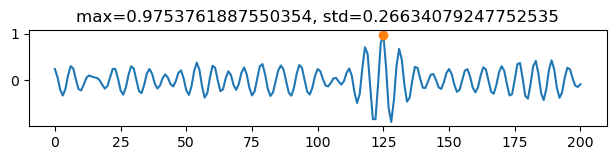

In [84]:
# procedural test of windowing and timing offsets 
rangeoffset = -Second(0):Second(1):Second(200)

thisdt = DateTime(2024,6,8) # select day
dtl, yl, dts, ys = load_vn_lidar_data(thisdt, Vn)

limdt = thisdt + Hour(1) + Minute(1) .+ Minute.([0, 3])

# test computing one covariance
offset = Second(126)

jl = findall(limdt[1] .<= dtl-offset .<= limdt[2])
# comb the time indices out of VN dts
js = findindices(dtl[jl] - offset, dts) # findindices( needles, haystack )
nn = @. good(yl[jl]) & good(ys[js])
a_cov = cov(yl[jl][nn], ys[js][nn])

# test computing a range of covariances
rangecovs = Vector{Float64}(undef, length(rangeoffset))
for (i, offset) in enumerate(rangeoffset)
    jl = findall(limdt[1] .<= dtl-offset .<= limdt[2])
    # comb the time indices out of VN dts
    js = findindices(dtl[jl] - offset, dts) # findindices( needles, haystack )
    nn = @. good(yl[jl]) & good(ys[js])
    rangecovs[i] = cov(yl[jl][nn], ys[js][nn])
end
maxcov, imax = findmax(rangecovs)

clf()
subplot(3,1,1)
plot(Dates.value.(rangeoffset), rangecovs)
plot(Dates.value.(rangeoffset[imax]), maxcov, marker="o")
title("max=$(maxcov), std=$(std(rangecovs))")
gcf()

Positive offsets make the l window select from forward in the original l timeseries, 
and shift the data in this window backward to compare with an earlier 
(0-offset) time in the s series.
Thus l signals are advanced to earlier times to align with earlier (0 offset).
signals in the s series. 

This disagram depicts the alignment of the windows of the
Halo and VectorNav data windows.
```
                 ---> time
Halo    l   ---|----signals |ere----        Halo time series with |requested window|
            --->>>>[signals here]---   >>>> offset
            ---[signals here]<<<<---   <<<< aligns later l data with s data
            ---[vecnavs gnal]-------        nearest points to nonmissing data in window
VecNav  s   ---|vecnavsignal|-------
```

In [85]:
# fit offset function
"""
fit_offset(dt_lidar_chunk) returns offset (seconds) that lidar needs to advance to match the VN,
using hardcoded linear fit derived from pitch solid-body rotation.
"""
function fit_offset(dt)
    # slope = diff(Dates.value.(Millisecond.(offset[[1, end-4*150]])))[1] / Dates.value(diff(cdt_st[[1, end-4*150]])[1])
    slope = -2.4805283261947786e-5
    # 2 pieces
    if dt < DateTime(2024,6,6,11,15)
        origin_time   = DateTime(2024,5,1,23,51,47,117)
        origin_offset = 143.8 #.8062
    else
        origin_time   = DateTime(2024,6,6,23,33,44,321)
        origin_offset = 126.94
    end
    origin_offset + Dates.value(Millisecond(dt - origin_time))/1_000 * slope
end

fit_offset(DateTime(2024,5,1))

#=
# plot the fit
# quality condition
ii = maxcov./stdcov .> 4

clf()
subplot(2,1,1)
plot(cdt_st, Dates.value.(Second.(offset)),
    marker=".", markersize=1, linestyle="none")
plot(cdt_st[ii], Dates.value.(Second.(offset[ii])),
    marker=".", markersize=4, linestyle="none")
plot(cdt_st[ii], fit_offset.(cdt_st[ii]))
plot(cdt_st[ii], round.(Int32, fit_offset.(cdt_st[ii])))
ylim([115, 150])
xlim([DateTime(2024,5,1), DateTime(2024,5,14,6)])
# xlim([DateTime(2024,6,6,10), DateTime(2024,6,6,12)])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m%d"))
subplot(2,1,2)
plot(cdt_st, Dates.value.(Second.(offset)),
    marker=".", markersize=1, linestyle="none")
plot(cdt_st[ii], Dates.value.(Second.(offset[ii])),
    marker=".", markersize=4, linestyle="none")
plot(cdt_st[ii], fit_offset.(cdt_st[ii]))
plot(cdt_st[ii], round.(Int32, fit_offset.(cdt_st[ii])))
ylim([60, 130])
xlim([DateTime(2024,6,1,23), DateTime(2024,6,10,3)])
# xlim([DateTime(2024,6,6,10), DateTime(2024,6,6,12)])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m%d"))
gcf()
=#

# good enough!

145.9309503714023

In [86]:
# get all the files, and all the unique hours of the files
allstarefiles = vcat( [ joinpath.("data",F, 
    filter( startswith(r"Stare_"), readdir(joinpath("data",F)) ) ) 
  for F in filter( startswith(r"20240"), readdir("data") ) ]... )

REm = match.(r"Stare_116_(\d{8}_\d{2}).hpl", allstarefiles)
dth = [ DateTime(r[1], dateformat"yyyymmdd_HH") for r in REm ]
unique(floor.(dth, Hour)) # all 991 are already unique

967-element Vector{DateTime}:
 2024-04-28T00:00:00
 2024-04-28T01:00:00
 2024-04-28T02:00:00
 2024-04-28T03:00:00
 2024-04-28T04:00:00
 2024-04-28T05:00:00
 2024-04-28T06:00:00
 2024-04-28T07:00:00
 2024-04-28T08:00:00
 2024-04-28T09:00:00
 ⋮
 2024-06-12T22:00:00
 2024-06-12T23:00:00
 2024-06-13T00:00:00
 2024-06-13T01:00:00
 2024-06-13T02:00:00
 2024-06-13T03:00:00
 2024-06-13T04:00:00
 2024-06-13T05:00:00
 2024-06-13T06:00:00

## line up mean vertical velocity with platform heave
using VectorNav - POSMV analysis in [`vectornav.ipynb`](vectornav.ipynb)

Timing between POSMV and VectorNav (VN) is determined in 
[`rot_sandbox.ipynb`](rot_sandbox.ipynb).

Use 
  - POSMV GPS time 
and 
  - VN computer time

No timing adjustments help or are needed for POSMV and VN then agree to within ~±0.5s. This applies to both legs 1 and 2.

## load data sets

We get good autocovariance peaks for syncing
the solid-body pitching of the lidar and the VN.
Did pitch correction never work on ASTraL, or break very early on in leg 1?

Procedures might differ for different legs.

## Timing issues

VectorNav data, is presumably physically aligned with the coordinate system of the lidar in leg 1. At least its heave is aligned with the vertical lidar beams.

VectorNav clock drifts a few seconds and then corrects, or precesses, with a 51-hour cycle, compared to the POSMV. (I said 13-h cycle, but the figure shows a ~51 h cycle.)

2025 Feb 18: The VN computer clock and POSMV GPS clocks agree.

## Define TKE dissipation functions

In [ ]:
# functions for epsilon from stare w
# called in loop

# for testing
# seconds since dt0
"offset seconds since dt0"
toffs(dt, dt0=DateTime(2024,4,1)) = Millisecond( dt - dt0 ).value / 1000 # seconds
"datetime by adding time in seconds to dt0. Inverse of toffs"
tons(toffs, dt0=DateTime(2024,4,1)) = Millisecond(round(Int64, 1000*toffs)) + dt0

#= usage
vntoffs = toffs.( Vn["time"] )
# test indavg
vndt_int = tons.(indavg( vntoffs, ind ))
=#

#=
# arguments too abstract!
"diagnostic plot for doppler vel adjustment"
function plot_stare_motcor( stare1dt, height, dopplervel, mdv, pitch, roll, Ur, Vr, surgevel, swayvel, heaveveldown )
    mm = @. minute(stare1dt) + (second(stare1dt) + millisecond(stare1dt)/1000 )/60

    wt = wtrue_trigs.(dopplervel.-heave, Ur, Vr, pitch*pi/180, roll*pi/180)
    # w  = wtrue.(dopplervel, Ur, Vr, heave, pitch, roll)
    #  wtrue( dopplervel, Ur, Vr, heaveveldown, roll, pitch )
    w  = wtrue.(dopplervel, Ur, Vr, surgevel, swayvel, heaveveldown, pitch, -roll)

    subplot(3,1,1)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("vel - mdv")
    ylim([0, 1])

    subplot(3,1,2)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(wt)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    # pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv_remove)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("w heave and tilt angle decompostion - old")
    ylim([0, 1])

    subplot(3,1,3)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("w heave and tilt angle decompostion")
    ylim([0, 1])

    tight_layout()
    # Corrections in wtrue (other than adding the -heave) do not seem to be important
    # at this time. Motion compensation is probably working, then.
    return gcf()
end
=#

# clf()
# plot_stare_motcor( stare1dt, height, dopplervel, mdv, -roll, pitch, Ur, Vr, -vn1, vn0, vn2 )
# gcf()

plot_stare_motcor

In [88]:
# structure function dissipation functions

# stucture function constants
C2ll = 2.0
epsilon(A) = sqrt(3/4 * A/C2ll)^3
# struf(epsilon, r,r1) = C2ll * epsilon^(2/3) * r^(2/3) * (4 - (r1/r)^2)/3
# instruf(w1,w2) = (w1-w2)^2
# rho(r1,r) = r^(2/3) * (1 - ((r1/r)^2)/4)
# zmid(z1,z2) = (z1 + z2) / 2
# plot bin averaged instruf vs rho
# fit 
# D = A*rho + noise
# for A and noise
# A = 4/3 * C2ll * epsilon^(2/3)

"bin average D2 in equally-populated bins of rho"
function equal_bin(rho, D2; nbin=200, nbin_out_max=17 )
    ii = findall(.!ismissing.(rho) .& .!ismissing.(D2) )
    nrho = length(ii)
    if nrho >= 20
        sp = sortperm(rho[ii])
        srho = rho[ii][sp]
        step = max(1,round(Int32,nrho/nbin))
        rhobin = [ 0; rho[ii][sp[step:step:nrho]] ]
        jj = findall(.!ismissing.(rhobin) .& isfinite.(rhobin))
        D2inbin = binavg(D2[ii], rho[ii], rhobin[jj])
        rhoinbin = binavg(rho[ii], rho[ii], rhobin[jj])
        nbin_out = min(nbin_out_max, length(rhobin))
        return nbin_out, rhobin[1:nbin_out], D2inbin[1:nbin_out], rhoinbin[1:nbin_out]
    else
        return 1, [missing], [missing], [missing]
    end
end

"""
structure function D2, rho, A, epsilon at each level from w stare
D2bin, rhobin, A, noise = D2_rho_stare( w, pitch, roll, Ur, Vr; out=17 )
"""
function D2_rho_stare( w, pitch, roll, Ur, Vr; nbin_out_max=17 )

    nbin_out = nbin_out_max
    
    (nt, nz) = size(w)
    A      = Vector{Union{Missing,Float64}}(missing, nz)
    noise  = Vector{Union{Missing,Float64}}(missing, nz)
    rhobin = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)
    D2bin  = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)
    for izo in 1:nz # loop vertically
        #=
        ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, izo) # might do outside the loop
        zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                          pitch,roll, w; timestep=timestep )
        rho = rhopair.(dr2, dz2) # approx r^2/3
        # bin average str fcn D2 in equally-populated bins of rho
        @show size(rho), size(D2)
        rhobin_, D2inbin_, rhoinbin_ = equal_bin(rho, D2)
        rhobin[:,izo] .= rhoinbin_[1:nbin_out]
        D2bin[ :,izo] .= D2inbin_[ 1:nbin_out]
        # regress to get A
        ii = .!ismissing.(rhobin[:,izo]) .& .!ismissing.(D2bin[:,izo])
        if sum(ii) > 2
            A[izo] = anom(rhobin[:,izo][ii]) \ anom(D2bin[:,izo][ii])
            noise[izo] = mean(D2bin[:,izo][ii]) - A[izo] * mean(rhobin[:,izo][ii]) # noise
        end
        =#
        ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, izo) # might do outside the loop
        zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                          pitch,roll, w; timestep=timestep )
        rho = rhopair.(dr2, dz2) # approx r^2/3
        # bin average str fcn D2 in equally-populated bins of rho
        nbin_actual, rhobin_, D2inbin_, rhoinbin_ = equal_bin(rho, D2; nbin_out_max=nbin_out_max)
        rhobin[1:nbin_actual,izo] .= rhoinbin_
        D2bin[ 1:nbin_actual,izo] .= D2inbin_
        # regress to get A
        ii = .!ismissing.(rhobin[1:nbin_actual,izo]) .& .!ismissing.(D2bin[1:nbin_actual,izo])
        if sum(ii) > 2
            A[izo] = anom(rhobin[1:nbin_actual,izo][ii]) \ anom(D2bin[1:nbin_actual,izo][ii])
            noise[izo] = mean(D2bin[1:nbin_actual,izo][ii]) - A[izo] * mean(rhobin[1:nbin_actual,izo][ii]) # noise
        end
    end
    return D2bin, rhobin, A, noise
end


D2_rho_stare

## Compute TKE dissipation in ~10 min chunks by hour

In [242]:
# reload code
if false | true
    include("read_lidar.jl")
    import .chunks
end

# load into Main global scope
read_stare_time  = Main.chunks.read_stare_time
read_stare_chunk = Main.chunks.read_stare_chunk

read_stare_chunk (generic function with 2 methods)

In [243]:
# test one chunk, line-by-line

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )

lidardaydir = lidardaydirs[4]
dt = Date(lidardaydir, dateformat"yyyymmdd")

epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)

Vn = read_vecnav_dict() # Dict{Symbol, Any}
# Vn = read_daily_Vn( dt )            # Dict
# load daily relative horizontal winds
UV = get_daily_meanuv( dt ) # NCDataset

lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[2]
splt = split(lidarfile, r"[_.]")
dt = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime

St, _ = read_streamlinexr_stare( dt )
height = St[:height][1:ntop]
# TO DO: read the next hour to get continuous chunk at end ...
st_chunks, en_chunks = read_stare_time( St, dt )


([411, 949, 1487, 2025, 2563], [948, 1486, 2024, 2562, 3100])

In [244]:
stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(round(Int64, St[:time] * 3_600_000 )) # 3202

ichunk = 3
st = st_chunks[ichunk]
    en = en_chunks[ichunk]
    lidar_clock_fast_by = Millisecond( round(Int64, 1_000 * fit_offset(stare_dt_raw[st])) )
    stare_dt = stare_dt_raw .- lidar_clock_fast_by # synced to within 1 s
    stare1dt = stare_dt[st:en] # subset for this chunk
    # read a chunk
    dopplervel, pitch, roll, vn0, vn1, vn2, Ur, Vr, mdv = read_stare_chunk( dt, St, Vn, UV, st, en )
    # cannot consistently sync heave and dopplervel
    #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
    w = dopplervel .- mdv 
    # subplot(2,1,1)
    # pcolormesh(pd(m2n.(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
    epsi_tmp[ichunk,:] = @. epsilon(max(0,A))

80-element Vector{Union{Missing, Float64}}:
 0.0005616186798227069
 0.0006753897087215515
 0.0
 0.002310829969679924
 0.0021233268358786775
 0.0014622152907403888
 0.0008051993182811913
 0.0004803610742923374
 0.0005392470018150969
 0.00023948571310561801
 ⋮
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing

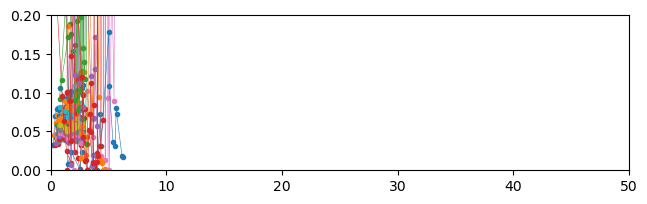

In [245]:
# plot D2 vs rho
clf()
subplot(2,1,1)
plot(m2n.(rhobin), m2n.(D2bin), marker=".", linewidth=0.4)
xlim([0, 50])
ylim([0, 0.2])
gcf()

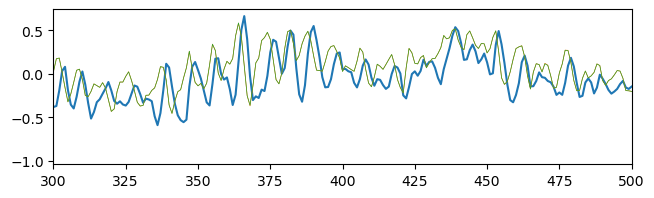

In [246]:
# plot test motion correction
# clf()
# plot_stare_motcor( stare1dt, height, dopplervel, mdv, roll, -pitch, Ur, Vr, -vn1, vn0, -vn2 )
# gcf()

# wt = wtrue_trigs.(dopplervel.-heave, Ur, Vr, pitch*pi/180, roll*pi/180)
wt = wtrue_trigs.(dopplervel.-vn2, Ur, Vr, pitch*pi/180, roll*pi/180)
# wtrue( dopplervel, surgevel, swayvel, heaveveldown, Ur, Vr, roll, pitch )
w  = wtrue.(dopplervel, 0, 0, -vn2, Ur, Vr, -pitch, roll) # looks good
w1  = wtrue.(dopplervel, -vn1, vn0, -vn2, Ur, Vr, -pitch, roll)
# vn0, vn1 0.1 horiz velocities that don't have much radial component

clf()
subplot(2,1,1)
plot(mdv)
# plot(mean.(skipmissing.(eachrow(wt))))
plot(mean.(skipmissing.(eachrow(w ))), linewidth=0.5)
plot(mean.(skipmissing.(eachrow(w1))), linewidth=0.5)
# plot(mean.(skipmissing.(eachrow(wtrue.(dopplervel, vn1, -vn0, vn2, Ur, Vr, pitch, -roll)))), linewidth=0.5) # good match to mdv
xlim([300, 500])
gcf()

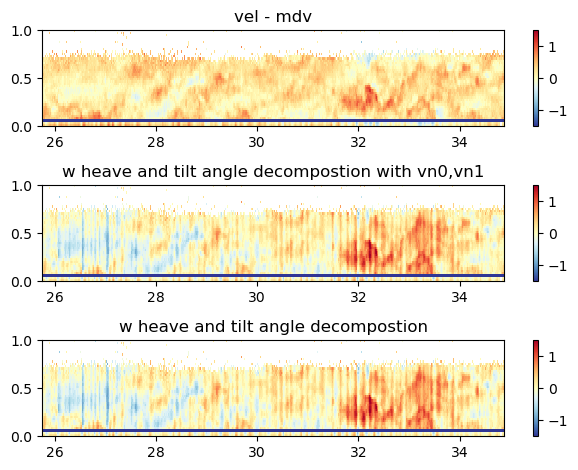

In [247]:
mm = @. minute(stare1dt) + (second(stare1dt) + millisecond(stare1dt)/1000 )/60

# wt = wtrue_trigs.(dopplervel.-heave, Ur, Vr, pitch*pi/180, roll*pi/180)
wt = wtrue_trigs.(dopplervel.-vn2, Ur, Vr, pitch*pi/180, roll*pi/180)
# wtrue( dopplervel, surgevel, swayvel, heaveveldown, Ur, Vr, roll, pitch )
w  = wtrue.(dopplervel,    0,   0, -vn2, Ur, Vr, -pitch, roll) # best
w2 = wtrue.(dopplervel,    0,   0, -vn2, 0, 0, -pitch, roll)
w1 = wtrue.(dopplervel, -vn1, vn0, -vn2, Ur, Vr, -pitch, roll)

clf()
subplot(3,1,1)
pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv)), cmap=ColorMap("RdYlBu_r"), vmin=-1.5, vmax=1.5)
colorbar()
title("vel - mdv")
ylim([0, 1])

subplot(3,1,2)
pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(w2)), cmap=ColorMap("RdYlBu_r"), vmin=-1.5, vmax=1.5)
# pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv_remove)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
colorbar()
title("w heave and tilt angle decompostion with vn0,vn1")
ylim([0, 1])

subplot(3,1,3)
pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1.5, vmax=1.5)
colorbar()
title("w heave and tilt angle decompostion")
ylim([0, 1])

tight_layout()
# Corrections in wtrue (other than adding the -heave) do not seem to be important
# at this time. Motion compensation is probably working, then.
gcf()


There are still stripes from the ship motion. I suspect it's not synced properly still.

The mdv adjustment completely eliminates the ship motion, but it also reduces variability longer than a few ship wave periods in the motion corrected radial velocity. Could lowpass filter the motion corrected velocity to restore this low frequency variability.

In [ ]:
# test: compute dissipation for one hour

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )

lidardaydir = lidardaydirs[5]
dt = Date(lidardaydir, dateformat"yyyymmdd")

epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)

Vn = read_vecnav_dict() # Dict{Symbol, Any}
# Vn = read_daily_Vn( dt )            # Dict
# load daily relative horizontal winds
UV = get_daily_meanuv( dt )

# another file in the same day
lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[12]
dt = Date(lidardaydir, dateformat"yyyymmdd")
epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)
UV = get_daily_meanuv( dt ) # daily
splt = split(lidarfile, r"[_.]")
dtm = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime

St, _ = read_streamlinexr_stare( dtm )
height = St[:height][1:ntop]
# TO DO: read the next hour to get continuous chunk at end ...
st_chunks, en_chunks = read_stare_time( St )
stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(round(Int64, St[:time] * 3_600_000 )) # 3202

for (ichunk, st) in enumerate(st_chunks)
    en = en_chunks[ichunk]
    lidar_clock_fast_by = Millisecond( round(Int64, 1_000 * fit_offset(stare_dt_raw[st])) )
    stare_dt = stare_dt_raw .- lidar_clock_fast_by # synced to within 1 s
    stare1dt = stare_dt[st:en] # subset for this chunk
    
    # read a chunk
    dopplervel, pitch, roll, heave, Ur, Vr, mdv = read_stare_chunk( dtm, St, Vn, UV, st, en )
    if any(isfinite.(Ur)) && any(isfinite.(Vr))
        # cannot consistently sync heave and dopplervel
        #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
        w = dopplervel .- mdv 
        D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
        epsi_tmp[ichunk,:] = @. epsilon(max(0,A))
    end
end


In [ ]:
# loop through lidar data and compute TKE dissipation rate

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )
epsi = Matrix{Union{Missing,Float64}}(missing, 6*24*60, ntop)
lidardtstart = zeros(DateTime, 6*24*60)
lidardtend   = zeros(DateTime, 6*24*60)

if false | true # comment out to save time
# compute epsilon for all stares 

    Vn = read_vecnav_dict() # Dict{Symbol, Any}

    # for lidardaydir in lidardaydirs[2:16] # files available leg 1
    # for lidardaydir in lidardaydirs[7:16] # files available leg 1
    for lidardaydir in lidardaydirs[17:end] # files available leg 2
        dt = Date(lidardaydir, dateformat"yyyymmdd") # a Date
        print("$(lidardaydir) ")
        # can't sync motion with clock!
        try # load daily vectornav  
            Vn_daily = read_daily_Vn( dt )            # Dict
        catch
            print("no VectorNav for $(dt)")
        end
        try # load daily relative horizontal winds
            UV = get_daily_meanuv( dt )         # NCDataset
        catch
            print("no mean wind for $(dt)\n")
            #save epsilon.jld2 just in case
            # jldopen("epsilon_tmp.jld2", "w+") do file
            #     file["epsilon"] = epsi
        end

        # load hourly lidar stares
        bigind = 0 # index time, save daily
        for lidarfile in filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))
            splt = split(lidarfile, r"[_.]")
            dtm = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime
            print("$(splt[4]) ")
            
            St, _ = read_streamlinexr_stare( dtm )
            height = St[:height][1:ntop]
            # TO DO: read the next hour to get continuous chunk at end ...

            st_chunks, en_chunks = read_stare_time( St )
            stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(round(Int64, St[:time] * 3_600_000 )) # 3202


            # stare_dt = @. ( dt 
            #     + Millisecond(round(Int64, St[:time] * 3_600_000 )) 
            #     - lidar_clock_fast_by )
            for (ichunk, st) in enumerate(st_chunks)
                en = en_chunks[ichunk]
                bigind += 1
                # synchronize clocks using the previously calculated offset function
                lidar_clock_fast_by = Millisecond( round(Int64, 1_000 * fit_offset(stare_dt_raw[st])) )
                stare_dt = stare_dt_raw .- lidar_clock_fast_by # synced to within 1 s
                stare1dt = stare_dt[st:en] # subset for this chunk
                try # read a chunk, collocate wind and VN data
                    dopplervel, pitch, roll, heave, Ur, Vr, mdv = read_stare_chunk( dtm, St, Vn, UV, st, en )
                    if any(isfinite.(Ur)) && any(isfinite.(Vr))
                        # cannot consistently sync heave and dopplervel
                        #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
                        w = dopplervel .- mdv 
                        D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
                        epsi[bigind,:] .= @. epsilon.(max(0,A))
                    else
                        epsi[bigind,:] .= -4 # code for missing wind
                    end
                catch
                        epsi[bigind,:] .= -5 # code for missing data, probably VN missing
                end
                lidardtstart[bigind] = stare_dt[st]
                lidardtend[bigind] = stare_dt[en]
            end
        end
        print("\n")
        #save data daily to epsilon.jld2
        fileout = "epsilon_$(Dates.format(dt, dateformat"yyyymmdd")).jld2"
        print("Saving $(fileout)\n")
        jldopen(fileout, "w+") do file
            file["epsilon"] = epsi[1:bigind,:]
            file["start_dt"] = lidardtstart[1:bigind]
            file["end_dt"]   = lidardtend[1:bigind]
        end
    end

end

# notes
# heave channel constant on 2024-5-12
# no mean wind on 2024-05-12
# 20240519 no VectorNav for 2024-05-19 00

20240504 00 01 02 03 04 05 06 07 08 

In [260]:
# just compute and save start and end times for stares
# print warnings to show data availability


lidardtstart = Vector{DateTime}(undef, 6*24*60)
lidardtend = Vector{DateTime}(undef, 6*24*60)

# for lidardaydir in lidardaydirs[2:16] # files available leg 1
# for lidardaydir in lidardaydirs[2:4] # files available leg 1
for lidardaydir in lidardaydirs[17:end] # files available leg 2
    dt = Date(lidardaydir, dateformat"yyyymmdd") # a Date
    print("$(lidardaydir) ")
    # can't sync motion with clock!
    try # load daily vectornav  
        Vn = read_daily_Vn(dt)            # Dict
    catch
        print("no VectorNav for $(dt)")
    end
    try # load daily relative horizontal winds
        UV = get_daily_meanuv(dt)         # NCDataset
    catch
        print("no mean wind for $(dt)\n")
        #save epsilon.jld2 just in case
        # jldopen("epsilon_tmp.jld2", "w+") do file
        #     file["epsilon"] = epsi
    end

    # load hourly lidar stares
    bigind = 0 # index time, save daily and reset bigind daily
    # read each hour in the day
    for lidarfile in filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir, lidardaydir)))
        splt = split(lidarfile, r"[_.]")
        dt = DateTime(splt[3] * splt[4], dateformat"yyyymmddHH") # a DateTime
        print("$(splt[4]):")

        # read 1 hour
        St, _ = read_streamlinexr_stare(dt)
        st_chunks, en_chunks = read_stare_time(St)
        stare_dt = @. ( dt 
            + Millisecond(round(Int64, St[:time] * 3_600_000 )) 
            - lidar_clock_fast_by )
        for (ichunk, st) in enumerate(st_chunks) # find time of each chunk
            en = en_chunks[ichunk]
            bigind += 1
            lidardtstart[bigind] = stare_dt[st]
            lidardtend[bigind]   = stare_dt[en]
        end
    end
    print("\n")
    #save data daily to epsilon.jld2
    fileout = "staredt_$(Dates.format(dt, dateformat"yyyymmdd")).jld2"
    print("Saving $(fileout)\n")
    jldopen(fileout, "w") do file
        file["start_dt"] = lidardtstart[1:bigind]
        file["end_dt"]   = lidardtend[1:bigind]
    end
end

20240520 no VectorNav for 2024-05-2000:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt_20240520.jld2
20240521 no VectorNav for 2024-05-2100:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt_20240521.jld2
20240522 no VectorNav for 2024-05-2200:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt_20240522.jld2
20240523 no VectorNav for 2024-05-2300:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt_20240523.jld2
20240524 no VectorNav for 2024-05-2400:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt_20240524.jld2
20240525 no VectorNav for 2024-05-2500:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt_20240525.jld2
20240526 no VectorNav for 2024-05-2600:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt_20240526.jld2
20240527 no VectorNav for 2024-05-

In [ ]:
jldopen("./epsilon_data/epsilon_tmp.jld2", "r") do file
    epsi = file["epsilon"]
    startdt = file["start_dt"]
    enddt = file["end_dt"]
end

pcolormesh(pd(m2n.(epsi)))

In [ ]:
# load whole array of epsilon from all daily files
epsdatapath = "./epsilon_data/"
# ntop = 80
ntime = 150*41

function readoneepsifile!(epsi, start_dt, end_dt, count, file)
    f = jldopen(file) # closes once function returns
    tmp = f["epsilon"]
    nadd = size(tmp, 1)
    epsi[count .+ (1:nadd), :] .= tmp
    start_dt[count .+ (1:nadd)] .= f["start_dt"]
    end_dt[  count .+ (1:nadd)] .= f["end_dt"]
    count + nadd
end

epsi = Matrix{Union{Missing, Float64}}(missing, (ntime, ntop))
start_dt = Vector{Union{Missing, DateTime}}(missing, ntime)
end_dt   = Vector{Union{Missing, DateTime}}(missing, ntime)
count = 0
for file in ( readdir(epsdatapath) |> filter(startswith("epsilon_")) |> filter(endswith(".jld2")) )
    count = readoneepsifile!(epsi, start_dt, end_dt, count, joinpath(epsdatapath, file))
    # print(count, " ")
end

# trim out trailing and missing
ii = findall(!ismissing, start_dt[1:count])
epsi = epsi[ii, :]
start_dt = start_dt[ii]
end_dt = end_dt[ii]
count

115 235 355 466 573 693 813 933 1053 1173 1293 1409 1520 1640 1745 1865 1985 2105 2225 2345 2465 2581 2693 2813 2933 3053 3173 3293 3412 3521 3641 3761 3882 4002 4122 4242 4349 4469 4589 4623 

4623

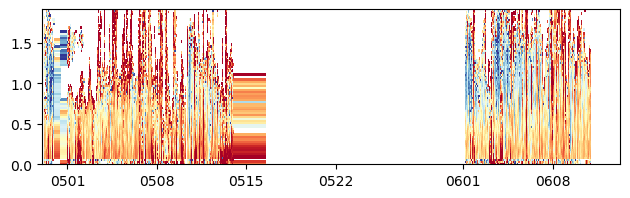

In [294]:
plotfilt(x) = (ismissing(x) || x<=0) ? NaN : x

clf()
subplot(2,1,1)
pcolor(start_dt, height/1e3, log10.(plotfilt.(pd(epsi))), vmin = -7, vmax = -3,
        cmap=ColorMap("RdYlBu_r"))
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m%d"))
gcf()

In [ ]:
# Tests

# check that St and Vn data are synced
clf()
subplot(2,1,1)
plot(hp(mdv))
plot(hp(heave))
xlim([400, 440])
# check lags
xc = xcorr( hp(mdv[:]), hp(heave) )
subplot(2,1,2)
plot( -(length(mdv)-1):length(mdv)-1, xc )
xlim([-40, 40])
#length(xc), 2*(length(mdv)-1) + 1
argmax(xc) - length(mdv) # 0-lag center moved to 0
# length(xc), length(mdv), 2*length(heave)


plot(mdv)
# plot(mdv_clean_heave)
# plot(mdv_clean_heavepitch)
# plot(mdv_clean_heavepitch)


plot(stare1dt, heave)
plot(stare1dt, mdv)
plot(stare1dt, mdv - heave) # subtract heave because its downward

## prepare the structure function analysis

In [ ]:
clf()
subplot(2,1,1)
plot(rhobin, D2bin, marker="*")
plot([0, 2.2*mean(rhobin[1:17])], noise .+ A.*[0, 2.2*mean(rhobin[1:17])])
xlim([0, 30])
xlabel(L"\rho = r^{2/3}"
title("TKE dissipation = 1.4 $\times 10^{-4}$")
epsilon(A) # 1.3e-4